# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$
M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
\end{pmatrix}
$$

$$
b = \begin{pmatrix}
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
\end{pmatrix}
$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [26]:
#--------------------------------------------------------------------
#Here we construct several key elements of the program such as classes as weel as the two functions that handle the boundary conditions and the main tri-diagonal   (this is done with sparse matrices to save memory and computational power - no need to compute all those zeroes!)
#--------------------------------------------------------------------
from scipy import sparse
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt

class Metal:
    def __init__(self, llambda: float, rho: float, C: float, L: float):
        self.llambda = llambda
        self.rho = rho
        self.C = C
        self.L = L

    def thermaldiff(self):
        return self.llambda / (self.rho * self.C)
    
Iron = Metal(llambda = 59, rho = 7900, C = 450, L = 0.5)

print("Thermal Diffusivity of our Iron rod:",Iron.thermaldiff())

class FiniteDifference:
    def __init__(self, N: int, t, x, d_0: float, d_N: float):
        self.N = N  #Dimension of matrix
        self.t = t  #temporal points
        self.x = x  #spatial points
        self.d_0 = d_0 #temperature at intial space point (x = 0.0)
        self.d_N = d_N  #temperature at final space point (x = 0.5)

    def tau(self, t):
        return t[1] - t[0]

    def h(self, x):
        return x[1] - x[0]

    def alpha(self, Metal):
        if Metal == 'test':
            k = 1
        else:
            k = Metal.thermaldiff()
        return (k *  self.tau(self.t)) / (self.h(self.x)**2)
    
    def MatrixMaker(self, Metal):
        N = self.N
        if Metal =='test':
            k = 1 
            a = self.alpha('test')
            return sparse.diags([-1 * a, (1 + 2*  a), -1 * a], [-1, 0, 1], shape = ((N-2, N-2))).toarray()
        else:
            a = self.alpha(Metal)
            return sparse.diags([-1 * a, (1 + 2*  a), -1 * a], [-1, 0, 1], shape = ((N-2, N-2)))

    def BoundaryCondition(self, bc: str, Metal) -> np.ndarray:
        a = self.alpha(Metal); N = self.N
        if bc =='dirichlet':
            B = np.zeros(N-2)
            B[0] = -a * self.d_0
            B[-1] = -a * self.d_N
            return B

    

        
        



times = np.linspace (0, 8, 9)
points = np.linspace(0, 8, 5)
TestMetal = Metal(llambda = 1, rho = 1, C = 1, L = 0.5)
TestMethod = FiniteDifference(5, times, points, 1000+273, 0+273)
print('\n')
print("Our value for alpha:", TestMethod.alpha('test')) 
print('\n')
print("Our Test Matrix:", "\n",TestMethod.MatrixMaker('test'))
print('\n')
print("Our Boundary Condition term for Dirichlet BC's:", TestMethod.BoundaryCondition('dirichlet', TestMetal))



Thermal Diffusivity of our Iron rod: 1.659634317862166e-05


Our value for alpha: 0.25


Our Test Matrix: 
 [[ 1.5  -0.25  0.  ]
 [-0.25  1.5  -0.25]
 [ 0.   -0.25  1.5 ]]


Our Boundary Condition term for Dirichlet BC's: [-318.25    0.    -68.25]


Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

In [3]:
#--------------------------------------------------------------------
#Now we go on to implement the implicit finite difference scheme to transport our temperature distribution along the rod to the next time step using .spsolve
#--------------------------------------------------------------------
def transport(FiniteDifference, u, Metal):
    A = FiniteDifference.MatrixMaker(Metal) 
    b = FiniteDifference.BoundaryCondition('dirichlet', Metal)
    B = u - b
    u_n1 = spsolve(A, B)
    return u_n1



Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

[[ 590.17366328  383.11447566  320.32617229 ...  292.44232301
   291.16092907  286.93523136]
 [ 748.93142568  479.30784645  363.87057376 ...  291.0416069
   288.8394735   283.17839451]
 [ 841.94622302  561.29785612  412.40617301 ...  289.65870385
   286.5767607   281.2162492 ]
 ...
 [1221.74770489 1171.69246547 1122.74584488 ...  272.02788385
   272.09195355  272.30323843]
 [1221.74770489 1171.69246547 1122.74584488 ...  272.02788385
   272.09195355  272.30323843]
 [1221.74770489 1171.69246547 1122.74584488 ...  272.02788385
   272.09195355  272.30323843]]


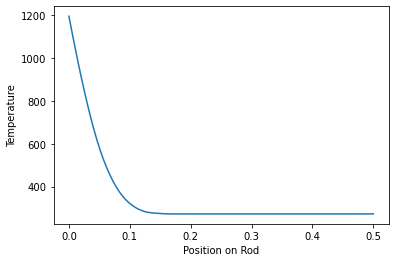

In [45]:
#--------------------------------------------------------------------
#Finally, we implement a simple loop to calculate the temperature distribution for all the time steps, and then plot using matplotlib.
#--------------------------------------------------------------------
def time_temp(FiniteDifference, T):
    grid = np.zeros((T, FiniteDifference.N-2))
    u = np.full(FiniteDifference.N-2, 293)
    # grid[0,] = transport(FiniteDifference, u, Iron)
    for k in range(0, T):
        # u[-1] = 0
        # u[0] = 1000
        # grid[:, 0] = u[0]
        # grid[:, -1] = u[-1]
        grid[k, ] = transport(FiniteDifference, u, Iron)
        u[:] = grid[k, ]
    return grid


# def time distribution(FiniteDifference, Max_Time):
#     u_n = np.zeros((FiniteDifference.N - 2, Max_T))

T = 500
ts = np.arange(0, T)
xs = np.linspace(0, Iron.L, 98)
Implicit = FiniteDifference(100, ts, xs, 1273, 273)

# def bigmat(FiniteDifference, maxt):
#     rod = np.zeros((FiniteDifference.N-2, maxt))
#     times = np.linspace(0, maxt, FiniteDifference.N-2)
#     for i in range(0, maxt):
#         rod[:] = main(FiniteDifference, times[i])
#         rod[:].append(main(FiniteDifference, times[i+1]))
#     return rod
        



print(time_temp(Implicit,T))

intensity = np.transpose(time_temp(Implicit, T))

# plt.pcolor(time_temp(Implicit, T))
# plt.ylabel('Time')
plt.xlabel('Position on Rod')
plt.ylabel('Temperature')
# plt.colorbar()
plt.plot(xs, time_temp(Implicit, T)[99, :])
plt.show()








## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two noces have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$
M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
\end{pmatrix}
$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.